# Feature Extraction and Classification: NLP Approach
This notebook focuses on extracting textual features from product descriptions and performing clustering to validate the feasibility of automatic classification for consumer goods.


In [1]:
# Librairies import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import time
import warnings

from nltk.corpus import stopwords
from nltk import PorterStemmer, WordNetLemmatizer
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
from matplotlib.image import imread

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import test_functions as pf

# Data Loading and Exploration

In [4]:
data = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv", sep=",")
print(data.shape)

(1050, 15)


In [5]:
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
data.isna().sum()

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64

The **dataset is very well filled in**. Missing brand values can be replaced with a “”.

In [ ]:
data["brand"].fillna("", inplace=True)

In [9]:
data.isna().sum().sum()

3

There are only 3 missing values, which can be ignored for the moment.

Let's look at the category column:

In [10]:
data.product_category_tree

0       ["Home Furnishing >> Curtains & Accessories >>...
1       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2       ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4       ["Home Furnishing >> Bed Linen >> Bedsheets >>...
                              ...                        
1045    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049    ["Baby Care >> Baby & Kids Gifts >> Stickers >...
Name: product_category_tree, Length: 1050, dtype: object

It seems that each product is categorized by a tree system with several levels. 

In [11]:
# Exemple de la catégorie du premier produit
print(data["product_category_tree"][0])

["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]


First-level extraction :

In [12]:
data["product_category_tree"][0].split(">>")[0].split("\"")[1].strip()

'Home Furnishing'

Level 0 and 1 categories are extracted from all products:

In [ ]:
# We retrieve the “product_category_tree” column
list_categories_0, list_categories_1 = [], []
for txt in data["product_category_tree"] :
    
    list_categories_0.append(txt.split(">>")[0].split("\"")[1].strip()) # split the name with >> and retrieve the first part
    list_categories_1.append(txt.split(">>")[1].strip()) # split the name with >> and retrieve the first part

# Creation of a new category series     
data["category_0"] = pd.Series(list_categories_0)
data["category_1"] = pd.Series(list_categories_1)

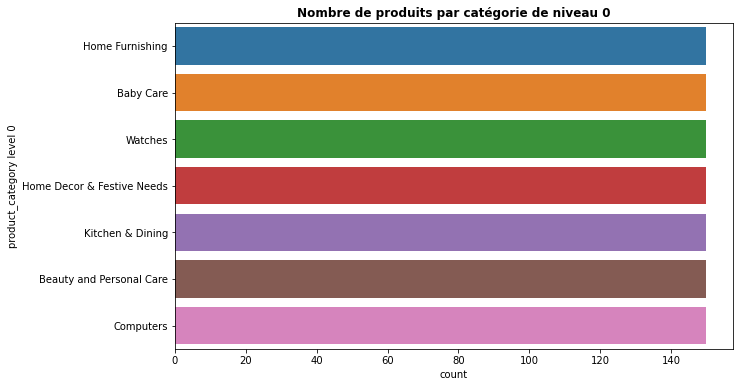

In [14]:
fig = plt.figure(figsize=(10, 6))
sns.countplot(data=data, y="category_0",
             order = data["category_0"].value_counts().index)
plt.yticks()
plt.title("Nombre de produits par catégorie de niveau 0", fontweight="bold")
plt.ylabel("product_category level 0")
plt.show()

There are **7 level 0 categories, all well distributed**.

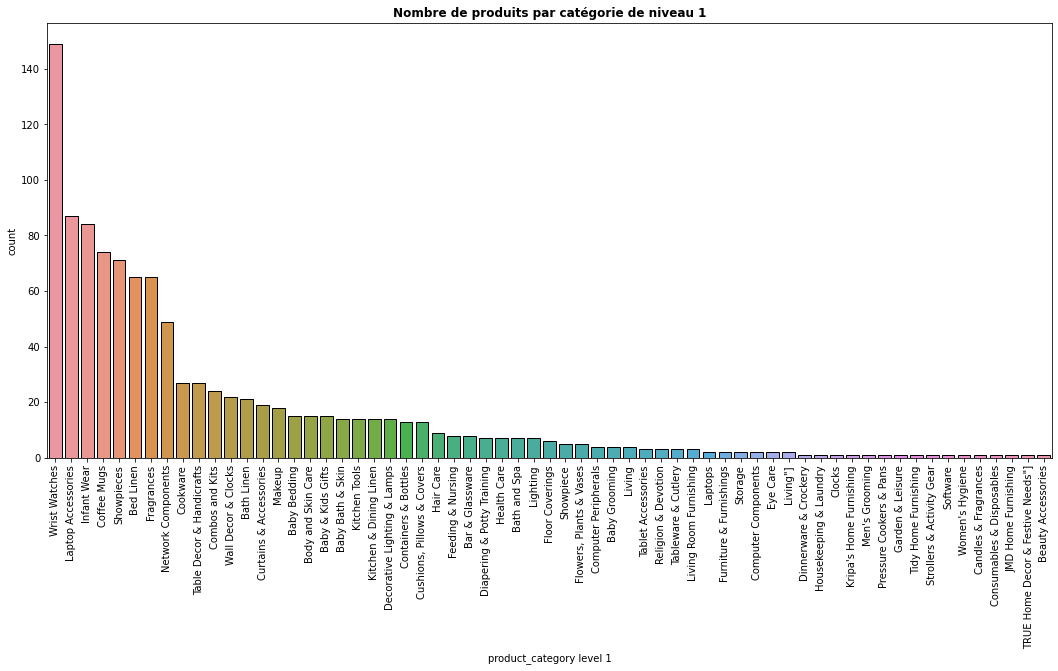

In [15]:
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data, x="category_1",
              edgecolor="black",
              order = data['category_1'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Nombre de produits par catégorie de niveau 1", fontweight="bold")
plt.xlabel('product_category level 1')
plt.show()

In [16]:
data['category_1'].value_counts().count()

63

There are 63 categories in level 1, so we'll be working with level 0 to study the feasibility of classification.

Display a random product in the database:

In [17]:
data_product = data[data.image == "1fcff864d6e397e1424d5366e6c6b8fa.jpg"]
data_product.reset_index(inplace=True)

In [18]:
print(data_product.product_name)

0    HMT Sonata Gold Plated Watch For Men Sonata An...
Name: product_name, dtype: object


In [19]:
name_image = "1fcff864d6e397e1424d5366e6c6b8fa.jpg"
path = "../P6/Images/"

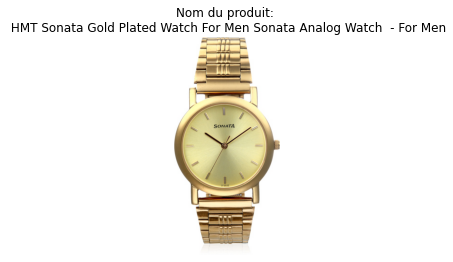

Catégorie: Watches
Description: HMT Sonata Gold Plated Watch For Men Sonata Analog Watch  - For Men - Buy HMT Sonata Gold Plated Watch For Men Sonata Analog Watch  - For Men  Sonata Gold Plated Watch For Men Online at Rs.899 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


In [20]:
filename = path + name_image
img = imread(filename)
plt.axis('off')   
plt.imshow(img)
plt.title("Nom du produit: \n "+ data_product.product_name[0])
plt.show()

print("Catégorie: "+ data_product.category_0[0])
print("Description: " + data_product.description[0])

We can first try out a cleaning function on the example above:

### Function `transform_bow_lem_fct`
This function prepares raw text for a Bag of Words representation by applying several preprocessing steps.

#### Steps:
1. **Tokenization:** Splits the text into individual words.
2. **Stopword Filtering:** Removes frequent, non-informative words (e.g., the, of, and).
3. **Lowercase Conversion:** Converts all words to lowercase for consistency.
4. **Lemmatization:** Reduces words to their canonical forms (e.g., "running" becomes "run").
5. **Reconstruction:** Rebuilds the text from the transformed words.

#### Objective:
Provide preprocessed text ready for machine learning models based on Bag of Words techniques.


In [ ]:
text_avant = data_product.description[0]
print("Texte avant traitement: \n\n"+ text_avant) #before 

Texte avant traitement: 

HMT Sonata Gold Plated Watch For Men Sonata Analog Watch  - For Men - Buy HMT Sonata Gold Plated Watch For Men Sonata Analog Watch  - For Men  Sonata Gold Plated Watch For Men Online at Rs.899 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!


In [ ]:
print("Après traitement: \n\n"+ pf.transform_bow_lem_fct(text_avant)) # after 

Après traitement: 

hmt sonata gold plated watch men sonata analog watch men buy hmt sonata gold plated watch men sonata analog watch men sonata gold plated watch men online rs.899 india great discount genuine product replacement guarantee free shipping cash delivery


---

# Bag of word - Tf- idf

In [23]:
data.head(2)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_0,category_1
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,Curtains & Accessories
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,Baby Bath & Skin


We can create a **data_T** dataframe for text analysis

In [24]:
data_T = data[["uniq_id","product_name","description","category_0"]]

In [25]:
data_T.head()

,uniq_id,product_name,description,category_0
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing


Description of the first product :

In [26]:
data_T.description[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

### Text Cleaning and Preparation Functions

In this section, we define functions to preprocess textual data. These functions clean the text and prepare it for feature extraction using various approaches such as Bag of Words, TF-IDF, or embeddings (e.g., BERT, USE).

#### 1. Function `transform_bow_fct`
This function prepares text for Bag of Words or TF-IDF models without lemmatization.
- **Steps:**
  1. Tokenizes the text into words.
  2. Removes stopwords (frequent, non-informative words).
  3. Converts all words to lowercase for consistency.
  4. Rejoins the cleaned words into a single string.
- **Purpose:** To provide a cleaned text suitable for CountVectorizer or TF-IDF transformations.

#### 2. Function `transform_bow_lem_fct`
This function prepares text for Bag of Words or TF-IDF models with lemmatization.
- **Steps:**
  1. Tokenizes the text into words.
  2. Removes stopwords (frequent, non-informative words).
  3. Converts all words to lowercase for consistency.
  4. Lemmatizes the words to reduce them to their base form (e.g., "running" -> "run").
  5. Rejoins the lemmatized words into a single string.
- **Purpose:** To enhance the quality of text representations for feature extraction by normalizing words to their base forms.

#### 3. Function `transform_dl_fct`
This function prepares text for deep learning models like BERT or USE (Universal Sentence Encoder).
- **Steps:**
  1. Tokenizes the text into words.
  2. (Optional) Removes stopwords (commented out for embeddings since context matters).
  3. Converts all words to lowercase for consistency.
  4. Rejoins the cleaned words into a single string.
- **Purpose:** To prepare text while preserving its contextual integrity, suitable for contextual embedding models.


In [27]:
#nettoyage
data_T['sentence_bow'] = data['description'].apply(lambda x : pf.transform_bow_fct(x))
data_T['sentence_bow_lem'] = data['description'].apply(lambda x : pf.transform_bow_lem_fct(x))
data_T['sentence_dl'] = data['description'].apply(lambda x : pf.transform_dl_fct(x))
data_T.shape

(1050, 7)

In [28]:
data_T.head(2)

,uniq_id,product_name,description,category_0,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...


In [29]:
data_T.description[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

In [30]:
data_T.sentence_bow[0]

'key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster25 color mu

In [31]:
data_T.sentence_bow_lem[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it feature eyelet style stitch metal ring.it make room environment romantic loving.this curtain ant wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal design surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight. specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model duster25 color multicolor di

In [32]:
data_T.sentence_dl[0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , elegance polyester multicolor abstract eyelet door curtain ( 213 cm in height , pack of 2 ) price : rs . 899 this curtain enhances the look of the interiors.this curtain is made from 100 % high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs . the surreal attention is sure to steal hearts . these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening , you create the most special moments of joyous beauty given by the soothing prints . bring home the elegant curtain that softly filters light in your room 

In [33]:
data_T.head()

,uniq_id,product_name,description,category_0,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


In [34]:
data_T['tokens_before'] = data_T['description'].apply(lambda x: pf.tokenizer_fct(x)) #avant traitement
data_T['tokens_after'] = data_T['sentence_bow_lem'].apply(lambda x: pf.tokenizer_fct(x)) #après traitement

In [35]:
print(data_T['tokens_before'][0]) #before treatment

['Key', 'Features', 'of', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', 'Floral', 'Curtain', ',', 'Elegance', 'Polyester', 'Multicolor', 'Abstract', 'Eyelet', 'Door', 'Curtain', '(', '213', 'cm', 'in', 'Height', ',', 'Pack', 'of', '2', ')', 'Price', ':', 'Rs', '.', '899', 'This', 'curtain', 'enhances', 'the', 'look', 'of', 'the', 'interiors.This', 'curtain', 'is', 'made', 'from', '100', '%', 'high', 'quality', 'polyester', 'fabric.It', 'features', 'an', 'eyelet', 'style', 'stitch', 'with', 'Metal', 'Ring.It', 'makes', 'the', 'room', 'environment', 'romantic', 'and', 'loving.This', 'curtain', 'is', 'ant', 'wrinkle', 'and', 'anti', 'shrinkage', 'and', 'have', 'elegant', 'apparance.Give', 'your', 'home', 'a', 'bright', 'and', 'modernistic', 'appeal', 'with', 'these', 'designs', '.', 'The', 'surreal', 'attention', 'is', 'sure', 'to', 'steal', 'hearts', '.', 'These', 'contemporary', 'eyelet', 'and', 'valance', 'curtains', 'slide', 'smoothly', 'so', 'when', 

In [36]:
print(data_T['tokens_after'][0]) #after treatment

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', '213', 'height', 'pack', 'price', '899', 'this', 'curtain', 'enhances', 'look', 'interiors.this', 'curtain', 'made', '100', 'high', 'quality', 'polyester', 'fabric.it', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring.it', 'make', 'room', 'environment', 'romantic', 'loving.this', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance.give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'these', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', '

### Evaluating Text Preprocessing Effectiveness

This step visualizes the top 10 most frequent words in each category before and after preprocessing. 

#### Purpose:
- Highlight patterns or noise (e.g., stopwords, punctuation) in the raw text.
- Assess improvements after preprocessing (e.g., meaningful word distributions).
- Guide further optimization of text cleaning for better feature extraction.


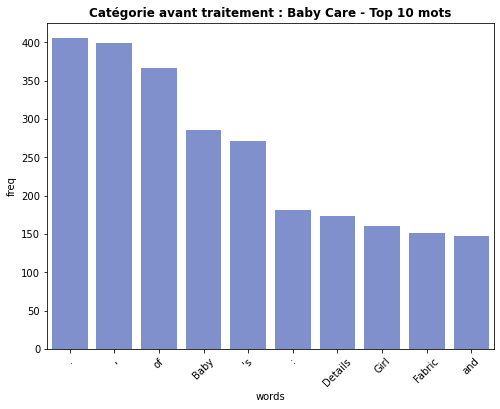

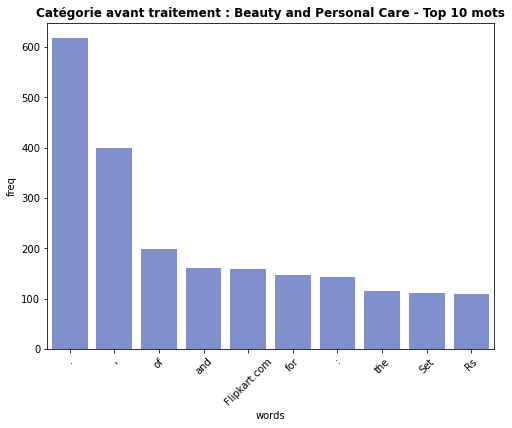

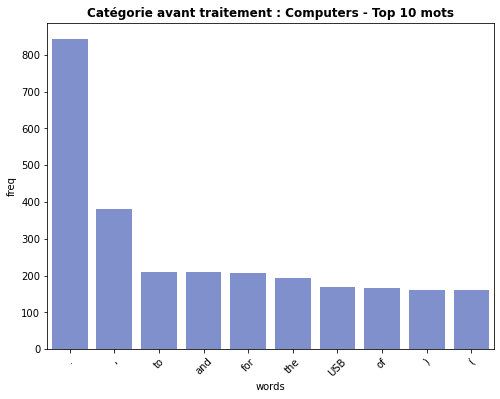

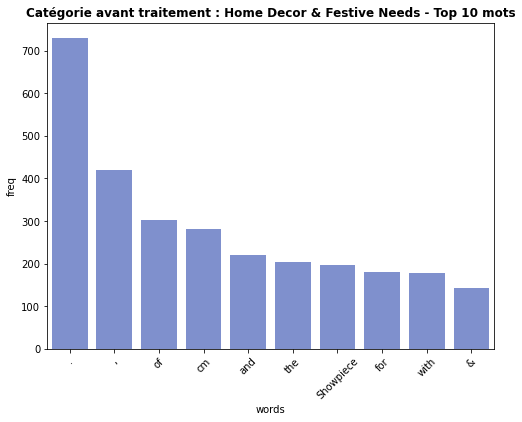

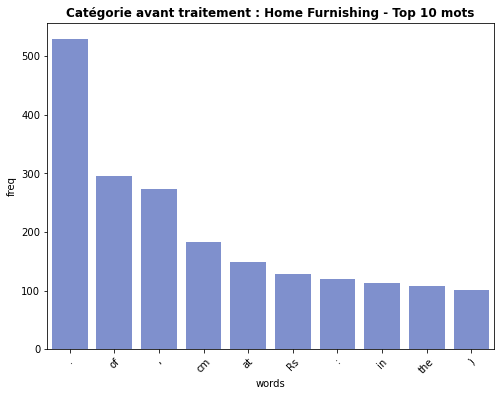

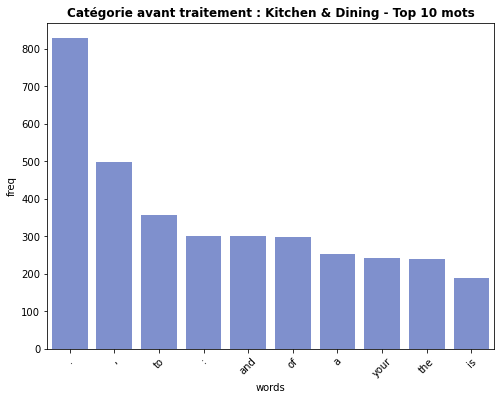

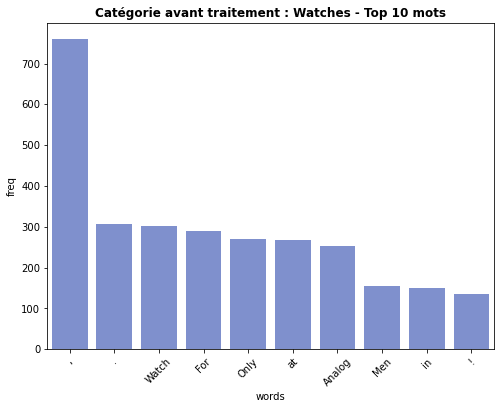

In [37]:
most_freq_dfs = pd.DataFrame()

for cat1, data_df in data_T.groupby("category_0"):
    most_freq_df = pf.get_most_freq(data_df["tokens_before"], 10).reset_index()
    most_freq_df["Category"] = cat1
    most_freq_dfs = pd.concat([most_freq_dfs, most_freq_df])
    pf.plot_freq_dist(most_freq_df, "Catégorie avant traitement : " + cat1 + " - Top 10 mots", 8, 6)

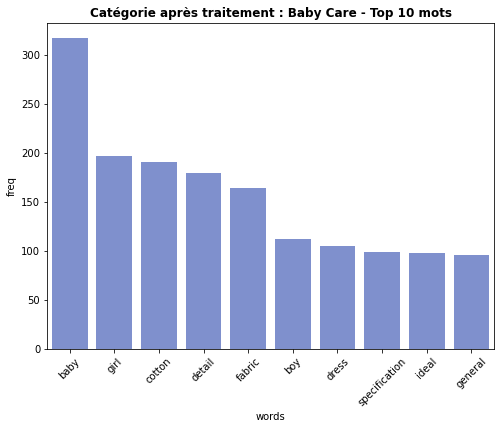

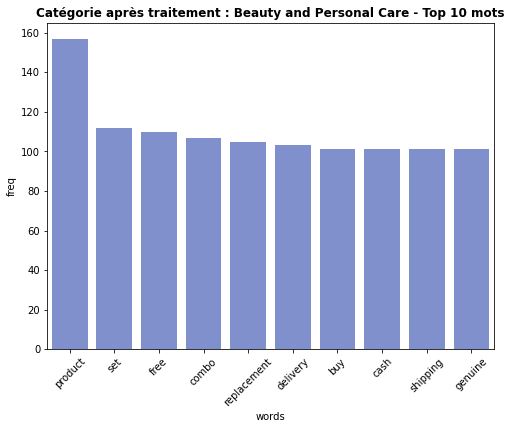

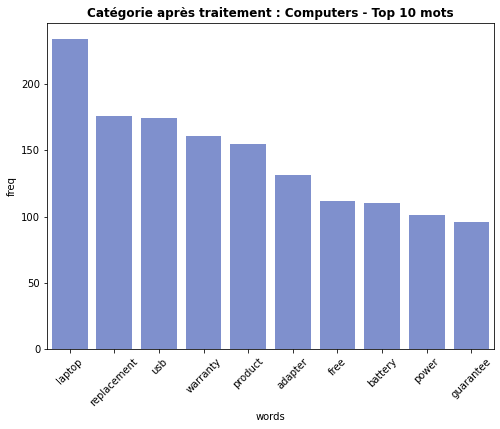

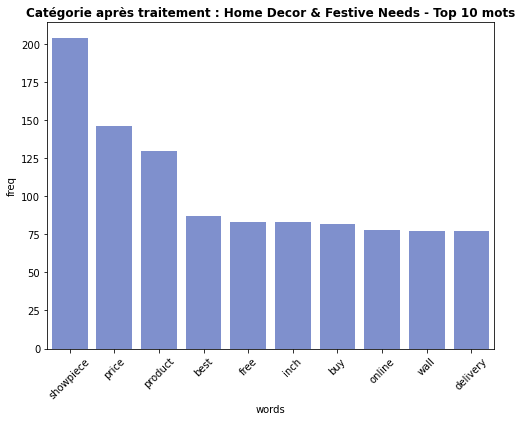

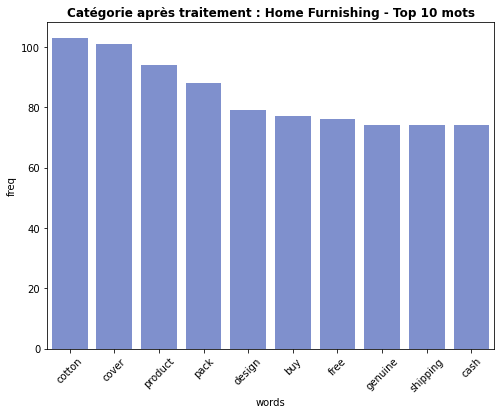

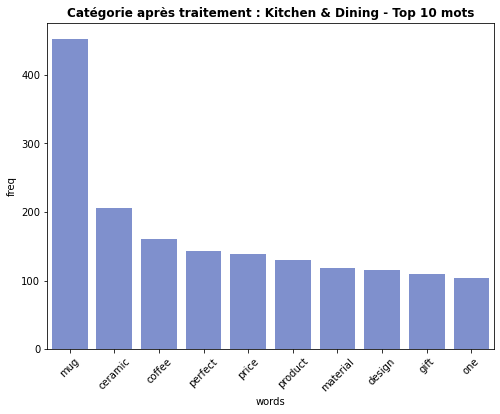

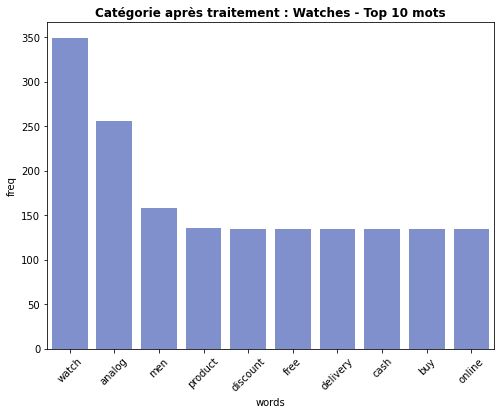

In [38]:
most_freq_dfs = pd.DataFrame()

for cat1, data_df in data_T.groupby("category_0"):
    most_freq_df = pf.get_most_freq(data_df["tokens_after"], 10).reset_index()
    most_freq_df["Category"] = cat1
    most_freq_dfs = pd.concat([most_freq_dfs, most_freq_df])
    pf.plot_freq_dist(most_freq_df, "Catégorie après traitement : " + cat1 + " - Top 10 mots", 8, 6)

### Results After Preprocessing

The visualization shows the top 10 most frequent words for the "Baby Care" category after text preprocessing. 

#### Observations:
- Noise (e.g., stopwords, punctuation) has been removed.
- The most frequent words now provide meaningful insights related to the category, such as "baby", "girl", "watch"...
- Preprocessing effectively improves text quality, making it more suitable for feature extraction and downstream tasks.

#### Conclusion:
The preprocessing pipeline appears to be working as intended, enhancing the clarity and relevance of textual features.

-------------------------------------------

### Encoding Categories and Analyzing Token Lengths

#### 1. Category Encoding
- **Purpose:** Convert categorical labels (`category_0`) into numerical values for model training.
- **Process:** Each unique category is assigned a numerical index. This is necessary for supervised learning algorithms that require numerical inputs.

#### 2. Token Length Analysis
- **Purpose:** Analyze the maximum token lengths in the preprocessed text (`sentence_bow` and `sentence_dl`).
- **Process:** 
  - `length_bow`: Calculates the maximum number of tokens for the Bag of Words representation.
  - `length_dl`: Calculates the maximum number of tokens for the Deep Learning representation.
- **Observations:** This helps determine padding or truncation requirements when preparing input for models like BERT or TF-IDF.

#### Next Steps:
- Use the encoded categories as target variables for classification tasks.
- Adjust padding/truncation lengths for models that require fixed-length inputs.


In [ ]:
#list containing the various categories
l_cat = list(set(data_T['category_0']))
print("catégories : ", l_cat)

catégories :  ['Beauty and Personal Care', 'Baby Care', 'Home Furnishing', 'Watches', 'Home Decor & Festive Needs', 'Kitchen & Dining', 'Computers']


In [40]:
#encoding categories
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['category_0'])) for i in range(len(data_T))]
print(y_cat_num)

[-1, 0, 0, -1, -1, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -2, -1, -1, -1, -3, -4, -4, -1, 0, -1, 0, 1, -4, -4, -4, -5, -4, 1, -4, -5, -4, -5, -5, -5, 1, 1, 1, 1, 1, 1, 1, 0, -4, -4, 0, -1, -4, -4, -4, -1, -4, 0, 0, 0, 1, 1, -1, 0, -3, -3, 0, 0, -3, -3, -4, -5, -1, -3, -3, -3, -3, -3, -3, -3, -3, -3, 1, 1, 1, -3, -3, -1, -1, -1, 0, -1, -1, -1, 0, -3, 0, -4, 0, -5, -3, 0, -3, -5, -1, 0, -5, -3, 1, 1, 1, 1, -3, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -4, -3, -3, -3, -3, -4, -3, -4, -3, -3, 0, -3, -4, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -4, -4, -3, -4, -3, 0, -3, -3, -4, -3, -3, -3, -3, -3, -3, -3, -3, -3, -3, -4, -4, -3, -3, -4, -3, -4, -4, -4, -4, -4, -4, -4, -4, -3, -4, -3, -4, -4, -4, -3, -4, -3, -3, -3, -

In [41]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())

max length bow :  373
max length dl :  632


### Bag of Words and TF-IDF Feature Extraction

In this step, we generate numerical representations of the preprocessed text (`sentence_bow_lem`) using Bag of Words and TF-IDF techniques.

#### Process:
1. **Vectorizer Initialization:**
   - `CountVectorizer`: Creates a sparse matrix with word counts.
   - `TfidfVectorizer`: Creates a sparse matrix with TF-IDF scores.
   - Parameters:
     - `stop_words='english'`: Removes common English stopwords.
     - `max_df=0.95`: Ignores words that appear in more than 95% of documents.
     - `min_df=1`: Considers only words appearing in at least one document.

2. **Fitting the Vectorizers:**
   - `cvect.fit`: Learns the vocabulary and word frequencies for Bag of Words.
   - `tfidf.fit`: Learns the vocabulary and TF-IDF scores.

3. **Transforming the Text:**
   - `cvect.transform`: Converts the text data into a Bag of Words matrix.
   - `tfidf.transform`: Converts the text data into a TF-IDF matrix.

#### Purpose:
To prepare numerical feature matrices for downstream machine learning tasks, enabling the model to work with textual data.


In [42]:
# création du bag of words (CountVectorizer et Tf-idf)

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
cv_fit = cvect.fit(data_T[feat])
ctf_fit = ctf.fit(data_T[feat])

cv_transform = cvect.transform(data_T[feat])  
ctf_transform = ctf.transform(data_T[feat])  

In [43]:
ctf_transform

<1050x5324 sparse matrix of type '<class 'numpy.float64'>'
	with 32905 stored elements in Compressed Sparse Row format>

### Evaluation of Feature Representations with ARI and Clustering

In this step, we evaluate the effectiveness of the Bag of Words and TF-IDF feature representations using clustering and Adjusted Rand Index (ARI).

#### Process:
1. **Dimensionality Reduction:**
   - We use t-SNE to project high-dimensional feature spaces into 2D for better clustering.
   - Parameters include:
     - `n_components=2`: Projects data to 2D.
     - `perplexity=30`: Influences the number of neighbors considered.
     - `n_iter=4000`: Number of optimization iterations.

2. **Clustering:**
   - K-Means is applied to the 2D t-SNE-transformed data to form clusters.
   - The number of clusters is set to match the number of unique categories.

3. **Adjusted Rand Index (ARI):**
   - ARI measures the similarity between the true labels (`y_cat_num`) and the clusters formed.
   - A higher ARI indicates better alignment of clusters with the true categories.

#### Results:
- **CountVectorizer:** ARI = 0.394, time = 8.0s.
- **TF-IDF:** ARI = 0.503, time = 8.0s.
- Observation: TF-IDF achieves better clustering alignment compared to Bag of Words.

#### Purpose:
To determine which text representation (Bag of Words or TF-IDF) provides better feature separability for downstream tasks.


In [44]:
print("CountVectorizer : ")
print("-----------------")
ARI1, X_tsne1, labels1 = pf.ARI_fct(cv_transform, l_cat, y_cat_num)
print()
print("Tf-idf : ")
print("--------")
ARI2, X_tsne2, labels2 = pf.ARI_fct(ctf_transform, l_cat, y_cat_num)

CountVectorizer : 
-----------------
ARI :  0.394 time :  8.0

Tf-idf : 
--------
ARI :  0.5027 time :  8.0


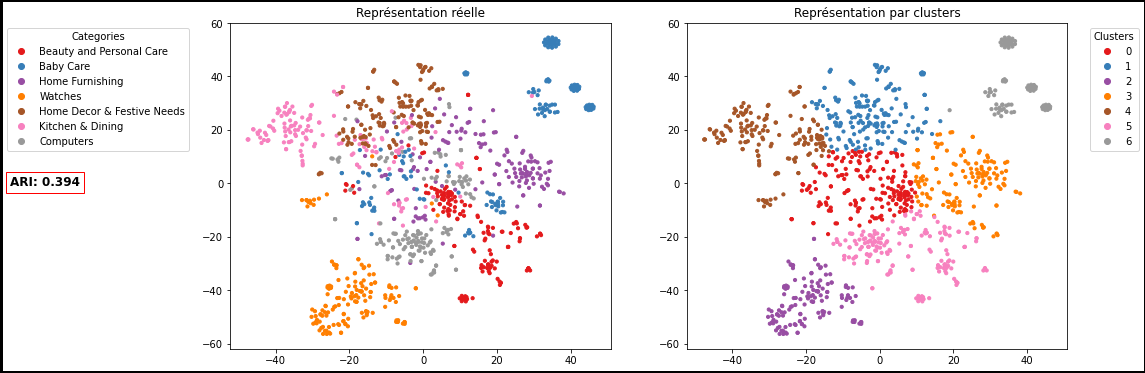

ARI :  0.394


In [45]:
#countvec
pf.TSNE_visu_fct(X_tsne1, y_cat_num, labels1, ARI1, l_cat)

### Visualization of t-SNE and Clustering Results

This visualization compares the true category distribution (left) with the clusters formed by K-Means after applying t-SNE (right). 

#### Observations:
1. **True Categories (Left Plot):**
   - The true categories show distinct groups, although some overlap exists between categories, indicating potential similarities in textual features.

2. **Clusters (Right Plot):**
   - The clusters formed by K-Means attempt to mimic the true categories but exhibit significant overlap and misclassification for certain groups.
   - Some categories are better separated than others, while others are mixed, suggesting room for improvement in feature representation.

3. **Adjusted Rand Index (ARI):**
   - The ARI score is **0.394**, indicating moderate alignment between true labels and predicted clusters.
   - This score suggests that while the CountVectorizer captures some useful features, it may not fully differentiate between all categories.

#### Interpretation:
- The visualization and ARI score highlight the limitations of CountVectorizer in capturing nuanced features for classification.
- Overlapping clusters suggest that some categories have similar vocabulary or insufficient distinguishing features.

In [46]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels1)
print(conf_mat)

[[  0   0   0   0   0  50   4   0  22   0  74   0]
 [  0   0   0   0   0  38   8   0  20   3   7  74]
 [  0   0   0   0   0  32  28   2  82   2   3   1]
 [  0   0   0   0   0   3   0 134   0  11   2   0]
 [  0   0   0   0   0   2 116   0   0  32   0   0]
 [  0   0   0   0   0  21  16   0   5 106   1   1]
 [  0   0   0   0   0  31   5   0  17   7  90   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


In [47]:
conf_mat= conf_mat[:7,5:]
conf_mat

array([[ 50,   4,   0,  22,   0,  74,   0],
       [ 38,   8,   0,  20,   3,   7,  74],
       [ 32,  28,   2,  82,   2,   3,   1],
       [  3,   0, 134,   0,  11,   2,   0],
       [  2, 116,   0,   0,  32,   0,   0],
       [ 21,  16,   0,   5, 106,   1,   1],
       [ 31,   5,   0,  17,   7,  90,   0]], dtype=int64)

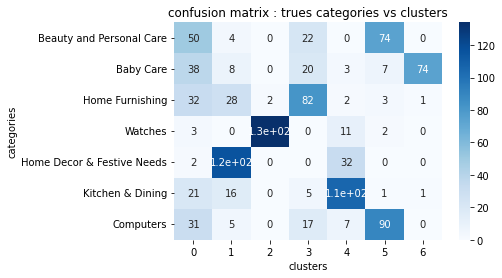

In [48]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

### Confusion Matrix: True Categories vs Clusters (CountVectorizer)

The confusion matrix compares the true categories with the clusters generated using K-Means based on the CountVectorizer representation.

#### Observations:
1. **Diagonal Values:**
   - High values on the diagonal indicate good alignment between true categories and clusters.
   - For example, the "Watches" category aligns well with cluster 3, showing that this cluster effectively captures this category.

2. **Off-Diagonal Values:**
   - Significant off-diagonal values indicate misclassifications.
   - For instance:
     - "Beauty and Personal Care" has a large overlap with cluster 5, suggesting confusion with another category.
     - "Home Furnishing" has notable misclassifications into clusters 0 and 1

3. **Category Overlaps:**
   - Some categories, such as "Baby Care" and "Beauty and Personal Care," overlap with multiple clusters, indicating that the features are not distinct enough to separate these categories.

#### Performance Insights:
- The CountVectorizer representation captures broad distinctions between categories but struggles with finer separations.
- Categories with similar vocabularies or insufficient textual distinction are prone to misclassification.

#### Next Steps:
1. Investigate if TF-IDF improves the feature separability.

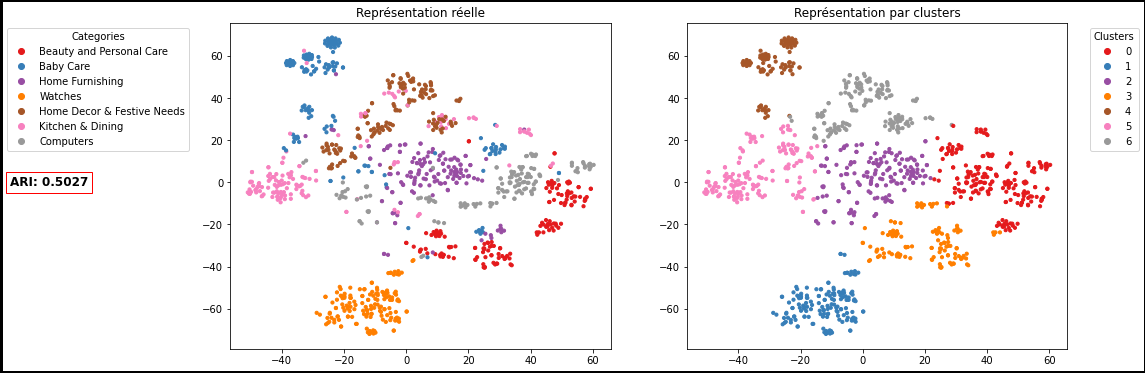

ARI :  0.5027


In [49]:
#tf_idf
pf.TSNE_visu_fct(X_tsne2, y_cat_num, labels2, ARI2, l_cat)

### TF-IDF Clustering Results

#### Observations:
- **ARI Improvement:** The ARI score increased from **0.394 (CountVectorizer)** to **0.503 (TF-IDF)**, showing better alignment between clusters and true categories.
- **Cluster Separation:** Clusters appear more distinct with less overlap compared to CountVectorizer.

#### Conclusion:
TF-IDF improves feature separability and clustering performance over CountVectorizer.


In [50]:
conf_mat2 = metrics.confusion_matrix(y_cat_num, labels2)
print(conf_mat2)

[[  0   0   0   0   0  68   0   2  80   0   0   0]
 [  0   0   0   0   0  22   0   9   9  87  20   3]
 [  0   0   0   0   0   4   3 127  11   1   4   0]
 [  0   0   0   0   0   0 148   0   2   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0  33 116]
 [  0   0   0   0   0  12   0   9   0   2  99  28]
 [  0   0   0   0   0  95   0  24  18   0  13   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


In [51]:
conf_mat2 = conf_mat2[:7,5:]
print(conf_mat2)

[[ 68   0   2  80   0   0   0]
 [ 22   0   9   9  87  20   3]
 [  4   3 127  11   1   4   0]
 [  0 148   0   2   0   0   0]
 [  0   0   1   0   0  33 116]
 [ 12   0   9   0   2  99  28]
 [ 95   0  24  18   0  13   0]]


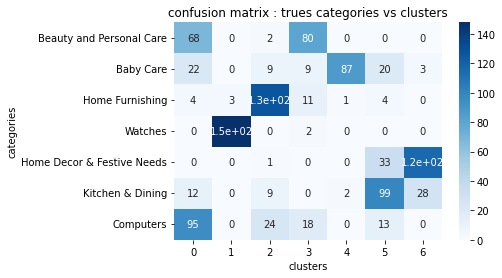

In [52]:
df_cm = pd.DataFrame(conf_mat2, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

In [53]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    conf_mat = conf_mat[:7,5:] #selecting values
    print(conf_mat)
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [54]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels2)
conf_mat_idf = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
conf_mat_idf = conf_mat_idf[:7,5:]

[[ 68   0   2  80   0   0   0]
 [ 22   0   9   9  87  20   3]
 [  4   3 127  11   1   4   0]
 [  0 148   0   2   0   0   0]
 [  0   0   1   0   0  33 116]
 [ 12   0   9   0   2  99  28]
 [ 95   0  24  18   0  13   0]]
Correspondance des clusters :  [6 3 2 0 1 5 4]


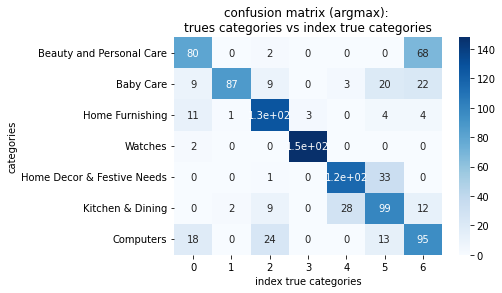

In [55]:
df_cm = pd.DataFrame(conf_mat_idf, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix (argmax): \ntrues categories vs index true categories")
plt.xlabel("index true categories")
plt.ylabel("categories")
plt.show()

### Confusion Matrix: True Categories vs Predicted Clusters (TF-IDF)

#### Observations:
1. **Improved Alignment:**
   - Higher diagonal values compared to CountVectorizer, indicating better clustering.
   - Categories like "Watches" and "Computers" show strong alignment with specific clusters.

2. **Remaining Confusion:**
   - Some categories, such as "Beauty and Personal Care" and "Baby Care," still exhibit overlap with other clusters, suggesting similarities in textual features.

#### Conclusion:
TF-IDF provides better separation and clustering accuracy than CountVectorizer but still struggles with certain overlapping categories.


# Word2Vec 

Unlike CountVectorizer and TF-IDF, Word2Vec uses a neural network to capture word meanings through their context, not just their frequency.


In [56]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [57]:
w2v_size= 10000
w2v_window= 5
w2v_min_count= 1
w2v_epochs= 100
maxlen = 200 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                max_vocab_size=w2v_size,
                                                seed=42,
                                                workers=10)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index2word
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4711
Word2Vec trained


In [ ]:
#tokenization
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4712


## Creating the embedding matrix

In [60]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 100
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4712, 100)


## Creating the embedding model

In [61]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 100)          471200    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 471,200
Trainable params: 471,200
Non-trainable params: 0
_________________________________________________________________


In [62]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 2ms/step


(1050, 100)

In [63]:
print("Dimensions dataset avant réduction PCA : ", embeddings.shape)
pca = decomposition.PCA(n_components=0.95)
pca_results_embeddings= pca.fit_transform(embeddings)
print("Dimensions dataset après réduction PCA : ", pca_results_embeddings.shape)

Dimensions dataset avant réduction PCA :  (1050, 100)
Dimensions dataset après réduction PCA :  (1050, 24)


In [64]:
ARI, X_tsne, labels = pf.ARI_fct(pca_results_embeddings, l_cat, y_cat_num)

ARI :  0.3538 time :  7.0


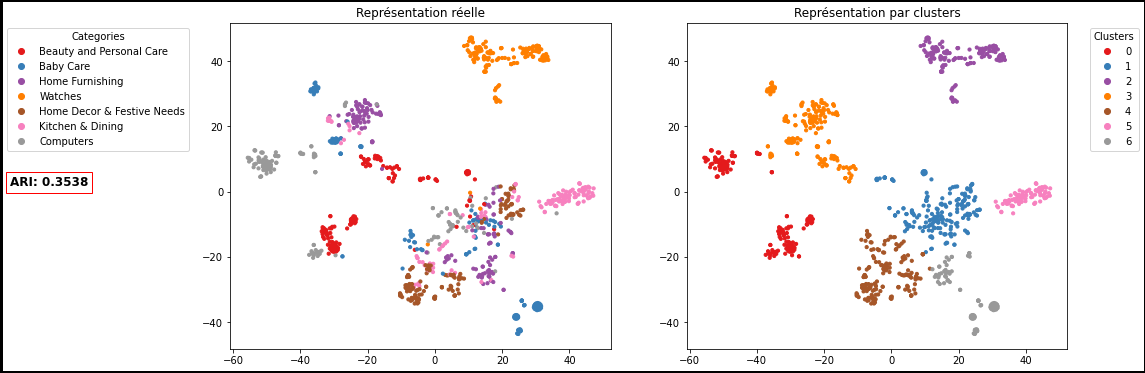

ARI :  0.3538


In [65]:
pf.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

### Word2Vec Clustering Results: Observations and Analysis

#### Observations:
- **ARI Score:** The ARI score is **0.353**, lower than both TF-IDF (0.503) and CountVectorizer (0.394).
- **Cluster Overlap:** Clusters are more scattered and less distinct compared to TF-IDF and CountVectorizer.

#### Possible Reasons for Lower Performance:
1. **Context Dependency:** 
   - Word2Vec focuses on capturing relationships between words rather than their overall importance within a document.
   - This can lead to less discriminative features for clustering, especially if category distinctions rely more on specific keywords.

2. **Lack of Aggregation:**
   - Word2Vec creates embeddings for individual words, and the document representation depends on aggregation (e.g., averaging). This can dilute the impact of unique or category-specific words.

3. **Limited Corpus Size:**
   - Word2Vec performs better with large corpora to learn meaningful embeddings. The dataset size here might not be sufficient to fully capture word relationships.

In [66]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels)
print(conf_mat)

[[  0   0   0   0   0  70  38   0  41   1   0   0]
 [  0   0   0   0   0   2  28   0  47  21   0  52]
 [  0   0   0   0   0   0  30   0  77  10   0  33]
 [  0   0   0   0   0   0   2 147   0   1   0   0]
 [  0   0   0   0   0   0  47   0   0 103   0   0]
 [  0   0   0   0   0   0  21   0  14  30  81   4]
 [  0   0   0   0   0  90  36   0  14   8   1   1]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


In [67]:
conf_mat= conf_mat[:7,5:]
conf_mat

array([[ 70,  38,   0,  41,   1,   0,   0],
       [  2,  28,   0,  47,  21,   0,  52],
       [  0,  30,   0,  77,  10,   0,  33],
       [  0,   2, 147,   0,   1,   0,   0],
       [  0,  47,   0,   0, 103,   0,   0],
       [  0,  21,   0,  14,  30,  81,   4],
       [ 90,  36,   0,  14,   8,   1,   1]], dtype=int64)

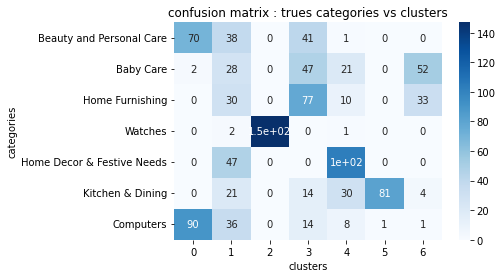

In [68]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

In [69]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels)
conf_mat_w2v = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
conf_mat_w2v = conf_mat_w2v[:7,5:]

[[ 70  38   0  41   1   0   0]
 [  2  28   0  47  21   0  52]
 [  0  30   0  77  10   0  33]
 [  0   2 147   0   1   0   0]
 [  0  47   0   0 103   0   0]
 [  0  21   0  14  30  81   4]
 [ 90  36   0  14   8   1   1]]
Correspondance des clusters :  [6 4 3 2 4 5 1]


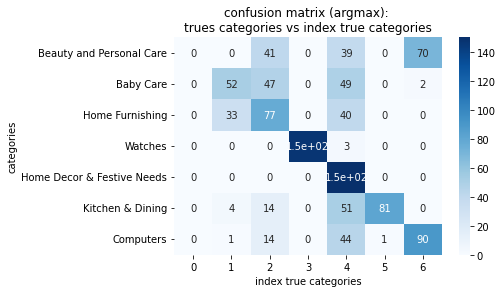

In [70]:
df_cm = pd.DataFrame(conf_mat_w2v, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix (argmax): \ntrues categories vs index true categories")
plt.xlabel("index true categories")
plt.ylabel("categories")
plt.show()

# BERT

### BERT: Contextual Sentence Embeddings

In this step, we will use **BERT (Bidirectional Encoder Representations from Transformers)** to generate contextual embeddings for the textual data.

#### What is BERT?
- BERT is a state-of-the-art transformer-based model that generates embeddings by understanding the context of each word in a sentence.
- Unlike Word2Vec, BERT considers both the left and right context of words, making it more powerful for capturing nuanced meanings.

#### What will we do?
1. Use a pre-trained BERT model (e.g., `bert-base-uncased`) to encode the descriptions.
2. Generate embeddings for each sentence/document as a single dense vector.
3. Use these embeddings as features for clustering and evaluate the results.

#### Purpose:
To explore whether BERT's contextual embeddings provide better cluster separability and alignment with true categories compared to previous methods.


In [71]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [72]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [73]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
#file= "bert_en_uncased_L-12_H-768_A-12_4.tar"
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [74]:
sentences = data_T['sentence_dl'].to_list()

In [75]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = pf.feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\alexi/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/bert-base-uncased/r

temps traitement :  67.0


In [76]:
print("Dimensions dataset avant réduction PCA : ", features_bert.shape)
pca = decomposition.PCA(n_components=0.95)
pca_results_bert= pca.fit_transform(features_bert)
print("Dimensions dataset après réduction PCA : ", pca_results_bert.shape)

Dimensions dataset avant réduction PCA :  (1050, 768)
Dimensions dataset après réduction PCA :  (1050, 153)


In [77]:
ARI, X_tsne, labels = pf.ARI_fct(pca_results_bert, l_cat, y_cat_num)

ARI :  0.3225 time :  8.0


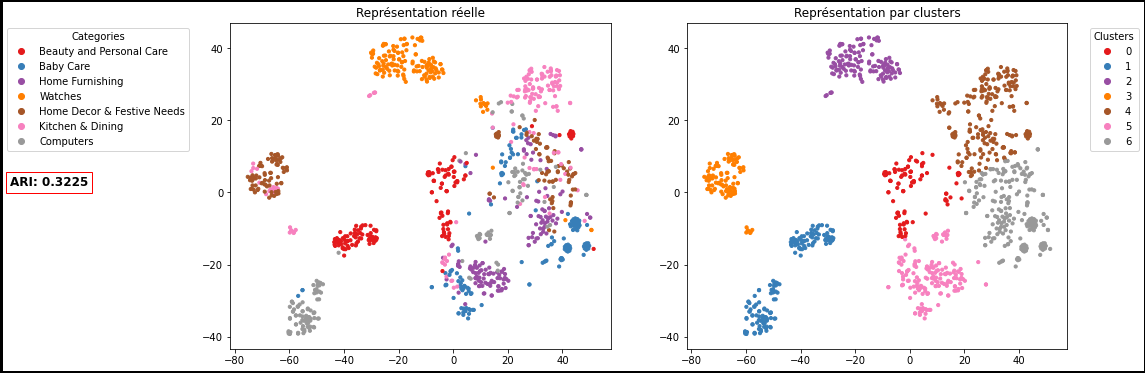

ARI :  0.3225


In [78]:
pf.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

### BERT Clustering Results: Analysis

#### Observations:
- **ARI Score:** The ARI score is **0.322**, which is lower than all previous methods (TF-IDF: 0.503, CountVectorizer: 0.394, Word2Vec: 0.353).
- **Cluster Overlap:** The clusters are poorly defined, with significant overlap between categories, indicating weak separability.

#### Why is BERT Performing Poorly?
1. **High Dimensionality:**
   - BERT embeddings are high-dimensional (768 dimensions by default), which can lead to sparse clustering results without sufficient dimensionality reduction or large datasets.

2. **Domain Mismatch:**
   - BERT is pre-trained on general text corpora, which may not align well with the specific vocabulary or structure of the dataset (e.g., e-commerce product descriptions).

3. **Aggregation Challenge:**
   - Sentence embeddings generated by BERT may lose important category-specific details, especially when categories have subtle textual differences.

4. **Dataset Size:**
   - BERT typically performs better with large datasets. The limited size of this dataset may not provide enough context for effective clustering.

#### Conclusion:
While BERT is powerful for many NLP tasks, its embeddings may not be ideal for clustering in this specific scenario due to high dimensionality, dataset size, and domain-specific challenges.

In [79]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels)
print(conf_mat)

[[  0   0   0   0   0  67  68   0   0  12   2   1]
 [  0   0   0   0   0   9   3   0   0  22  51  65]
 [  0   0   0   0   0   8   0   0   0  14  76  52]
 [  0   0   0   0   0   1   0 134   0  12   0   3]
 [  0   0   0   0   0   3   0   0  74  31   0  42]
 [  0   0   0   0   0   1   0   5  20  97  13  14]
 [  0   0   0   0   0   2  80   0   0  17  21  30]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


In [80]:
conf_mat= conf_mat[:7,5:]
conf_mat

array([[ 67,  68,   0,   0,  12,   2,   1],
       [  9,   3,   0,   0,  22,  51,  65],
       [  8,   0,   0,   0,  14,  76,  52],
       [  1,   0, 134,   0,  12,   0,   3],
       [  3,   0,   0,  74,  31,   0,  42],
       [  1,   0,   5,  20,  97,  13,  14],
       [  2,  80,   0,   0,  17,  21,  30]], dtype=int64)

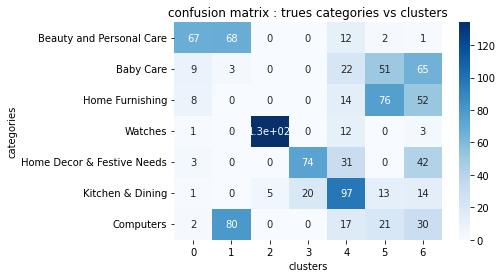

In [81]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

In [82]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels)
conf_mat_bert = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
conf_mat_bert = conf_mat_bert[:7,5:]

[[ 67  68   0   0  12   2   1]
 [  9   3   0   0  22  51  65]
 [  8   0   0   0  14  76  52]
 [  1   0 134   0  12   0   3]
 [  3   0   0  74  31   0  42]
 [  1   0   5  20  97  13  14]
 [  2  80   0   0  17  21  30]]
Correspondance des clusters :  [0 6 3 4 5 2 1]


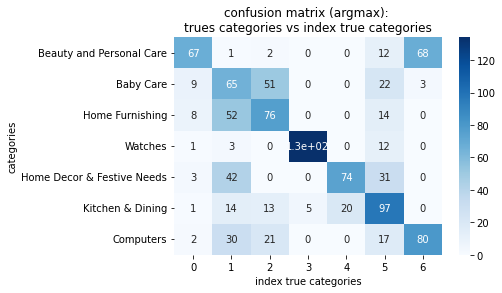

In [83]:
df_cm = pd.DataFrame(conf_mat_bert, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix (argmax): \ntrues categories vs index true categories")
plt.xlabel("index true categories")
plt.ylabel("categories")
plt.show()

# USE - Universal Sentence Encoder

In this step, we will use the **Universal Sentence Encoder (USE)** to generate embeddings for the product descriptions.

#### What is USE?
- USE is a pre-trained model optimized for encoding sentences or documents into fixed-length, dense vectors.
- Unlike Word2Vec or BERT, USE is designed specifically for sentence-level tasks, capturing the overall meaning of a sentence rather than individual word-level embeddings.

#### What will we do?
1. **Embed Descriptions:** Use the USE model to convert each product description into a single dense vector.
2. **Clustering:** Apply t-SNE for dimensionality reduction and K-Means for clustering, as done in previous steps.
3. **Evaluation:** Assess the cluster quality using the Adjusted Rand Index (ARI) and compare it to previous methods.

#### Purpose:
To evaluate if USE provides better cluster separability and alignment with true categories compared to other embedding techniques like BERT, Word2Vec, and TF-IDF.


In [84]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [85]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [86]:
features_USE = pf.feature_USE_fct(sentences, batch_size, embed)

In [87]:
print("Dimensions dataset avant réduction PCA : ", features_USE.shape)
pca = decomposition.PCA(n_components=0.99)
pca_results_use= pca.fit_transform(features_USE)
print("Dimensions dataset après réduction PCA : ", pca_results_use.shape)

Dimensions dataset avant réduction PCA :  (1050, 512)
Dimensions dataset après réduction PCA :  (1050, 312)


In [88]:
ARI, X_tsne, labels = pf.ARI_fct(pca_results_use, l_cat, y_cat_num)

ARI :  0.4459 time :  9.0


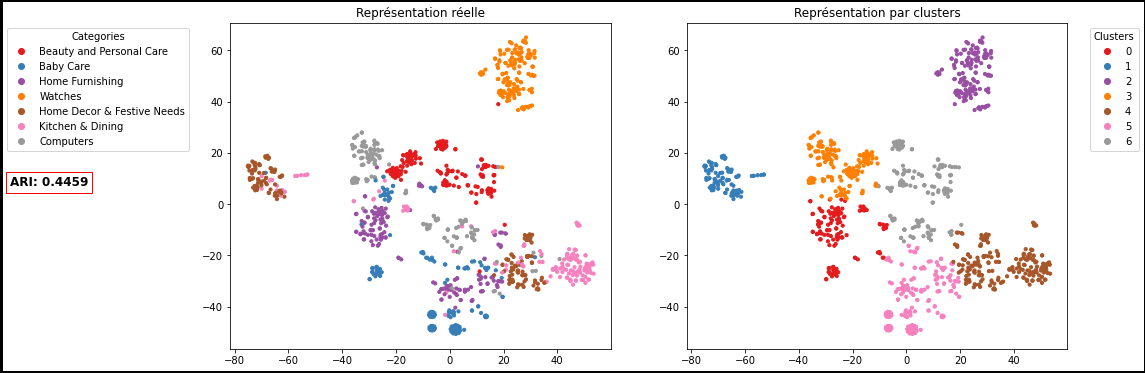

ARI :  0.4459


In [89]:
pf.TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, l_cat)

#### Observations:
- **ARI Score:** The ARI score is **0.445**, which is better than Word2Vec (0.353) and BERT (0.322), but still lower than TF-IDF (0.503).
- **Cluster Separation:** Clusters are more distinct compared to Word2Vec and BERT, but some overlap remains, particularly between categories with similar descriptions.

#### Why Does USE Perform Better?
1. **Sentence-Level Embeddings:**
   - USE captures the overall meaning of sentences, providing a more coherent representation for clustering tasks compared to word-level embeddings.
2. **Pretrained Optimization:**
   - USE is optimized for semantic similarity and performs well on medium-sized datasets like this one.

#### Limitations:
- **Overlap in Clusters:**
   - Categories with similar vocabulary or semantics (e.g., "Beauty and Personal Care" vs. "Baby Care") still show overlap.
- **Lower ARI than TF-IDF:**
   - TF-IDF's reliance on key term frequency might better distinguish categories with specific, repeated terms.

#### Conclusion:
USE outperforms BERT and Word2Vec in cluster separability, demonstrating the strength of sentence-level embeddings. However, TF-IDF still provides the best results for this specific dataset.

In [90]:
conf_mat = metrics.confusion_matrix(y_cat_num, labels)
print(conf_mat)

[[  0   0   0   0   0   0   0   1  51   0   1  97]
 [  0   0   0   0   0  29   1   0  18   1  95   6]
 [  0   0   0   0   0  73   0   0   6   7  58   6]
 [  0   0   0   0   0   0   0 149   0   0   0   1]
 [  0   0   0   0   0   0  74   0   0  75   1   0]
 [  0   0   0   0   0  11  20   0   3 106   5   5]
 [  0   0   0   0   0  10   0   0  84   7   9  40]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0]]


In [91]:
conf_mat= conf_mat[:7,5:]
conf_mat

array([[  0,   0,   1,  51,   0,   1,  97],
       [ 29,   1,   0,  18,   1,  95,   6],
       [ 73,   0,   0,   6,   7,  58,   6],
       [  0,   0, 149,   0,   0,   0,   1],
       [  0,  74,   0,   0,  75,   1,   0],
       [ 11,  20,   0,   3, 106,   5,   5],
       [ 10,   0,   0,  84,   7,   9,  40]], dtype=int64)

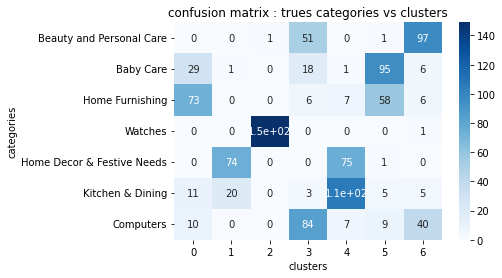

In [92]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix : trues categories vs clusters")
plt.xlabel("clusters")
plt.ylabel("categories")
plt.show()

In [93]:
cls_labels_transform = conf_mat_transform(y_cat_num, labels)
conf_mat_use = metrics.confusion_matrix(y_cat_num, cls_labels_transform)
conf_mat_use = conf_mat_use[:7,5:]

[[  0   0   1  51   0   1  97]
 [ 29   1   0  18   1  95   6]
 [ 73   0   0   6   7  58   6]
 [  0   0 149   0   0   0   1]
 [  0  74   0   0  75   1   0]
 [ 11  20   0   3 106   5   5]
 [ 10   0   0  84   7   9  40]]
Correspondance des clusters :  [2 4 3 6 5 1 0]


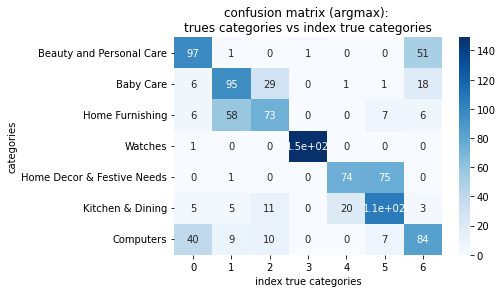

In [94]:
df_cm = pd.DataFrame(conf_mat_use, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])

plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.title("confusion matrix (argmax): \ntrues categories vs index true categories")
plt.xlabel("index true categories")
plt.ylabel("categories")
plt.show()

In [95]:
data_T.head()

,uniq_id,product_name,description,category_0,sentence_bow,sentence_bow_lem,sentence_dl,tokens_before,tokens_after,length_bow,length_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,Key Features of Elegance Polyester Multicolor ...,Home Furnishing,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...,"[Key, Features, of, Elegance, Polyester, Multi...","[key, feature, elegance, polyester, multicolor...",154,248
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,Specifications of Sathiyas Cotton Bath Towel (...,Baby Care,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...,"[Specifications, of, Sathiyas, Cotton, Bath, T...","[specification, sathiyas, cotton, bath, towel,...",62,84
2,64d5d4a258243731dc7bbb1eef49ad74,Eurospa Cotton Terry Face Towel Set,Key Features of Eurospa Cotton Terry Face Towe...,Baby Care,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...,"[Key, Features, of, Eurospa, Cotton, Terry, Fa...","[key, feature, eurospa, cotton, terry, face, t...",157,252
3,d4684dcdc759dd9cdf41504698d737d8,SANTOSH ROYAL FASHION Cotton Printed King size...,Key Features of SANTOSH ROYAL FASHION Cotton P...,Home Furnishing,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...,"[Key, Features, of, SANTOSH, ROYAL, FASHION, C...","[key, feature, santosh, royal, fashion, cotton...",114,148
4,6325b6870c54cd47be6ebfbffa620ec7,Jaipur Print Cotton Floral King sized Double B...,Key Features of Jaipur Print Cotton Floral Kin...,Home Furnishing,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...,"[Key, Features, of, Jaipur, Print, Cotton, Flo...","[key, feature, jaipur, print, cotton, floral, ...",156,228


---

 Saving the feature vector of the best model (tf_idf) for concatenation with the best image model

In [96]:
tf_idf_vector = ctf_transform.reshape(-1,1)
tf_idf_vector

<5590200x1 sparse matrix of type '<class 'numpy.float64'>'
	with 32905 stored elements in COOrdinate format>

In [97]:
tf_idf_vector = pd.DataFrame(tf_idf_vector.toarray()).to_numpy()
tf_idf_vector

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [98]:
tf_idf_vector.shape

(5590200, 1)

In [99]:
type(tf_idf_vector)

numpy.ndarray

In [100]:
np.save('tf_idf_vector.npy', tf_idf_vector) # save
#new_num_arr = np.load('data.npy') # load

## Conclusion and Next Steps

This notebook successfully explored and evaluated multiple text feature extraction techniques for clustering product categories. 

### Summary of Results:
1. **Best Technique:** TF-IDF achieved the highest Adjusted Rand Index (ARI) of **0.503**, demonstrating its effectiveness in distinguishing categories using term importance.
2. **Contextual Models:** While promising, Word2Vec, BERT, and USE underperformed due to limitations such as dataset size, domain specificity, and aggregation challenges.
3. **Clustering Outcome:** TF-IDF provided the clearest category separation, validating its use for this dataset.

### Next Steps:
The next phase of the project will focus on **image feature extraction** using techniques such as transfer learning models like VGG. The extracted visual features will complement the textual features (TF-IDF) to improve clustering and classification performance.

This combined approach will further refine the ability to categorize products automatically, leveraging both textual and visual data.


---